In [1]:
import scanpy as sc,os,pickle,sys,copy,scvelo as scv
import scanpy.external as sce,pandas as pd, numpy as np

In [3]:
adata_combined = sc.read_h5ad('/home/csj/mywork/ilc/220409-preprocessed_data/220516-CombinedABM.h5ad')
adata_combined.var_names_make_unique()

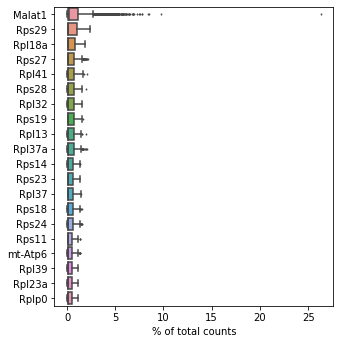

In [4]:
sc.pl.highest_expr_genes(adata_combined, n_top=20)

In [5]:
import copy
adata_combined.layers['counts'] = copy.copy(adata_combined.X)

In [10]:
adata_combined.obsm['umap_integrated']=adata_combined.obsm['umap'].copy()

In [20]:
adata_combined.obsm['X_umap']

array([[-0.6347948 , -2.8856704 ],
       [-3.6431048 , -5.538622  ],
       [-1.1535492 , -1.3094469 ],
       ...,
       [ 0.36826134, 14.47901   ],
       [-0.07733821, 15.301078  ],
       [ 1.4071425 , 10.935128  ]], dtype=float32)

In [6]:
sc.pp.normalize_total(adata_combined, target_sum=1e4)
sc.pp.log1p(adata_combined)
sc.pp.highly_variable_genes(adata_combined, flavor='seurat_v3',batch_key='orig.ident', n_top_genes=2000)
sc.tl.pca(adata_combined, svd_solver='arpack')
sc.pp.neighbors(adata_combined, n_neighbors=10, n_pcs=40)

In [16]:
sc.tl.umap(adata_combined, min_dist=0.4, random_state=0)

In [22]:
del adata_combined.obsm['umap']

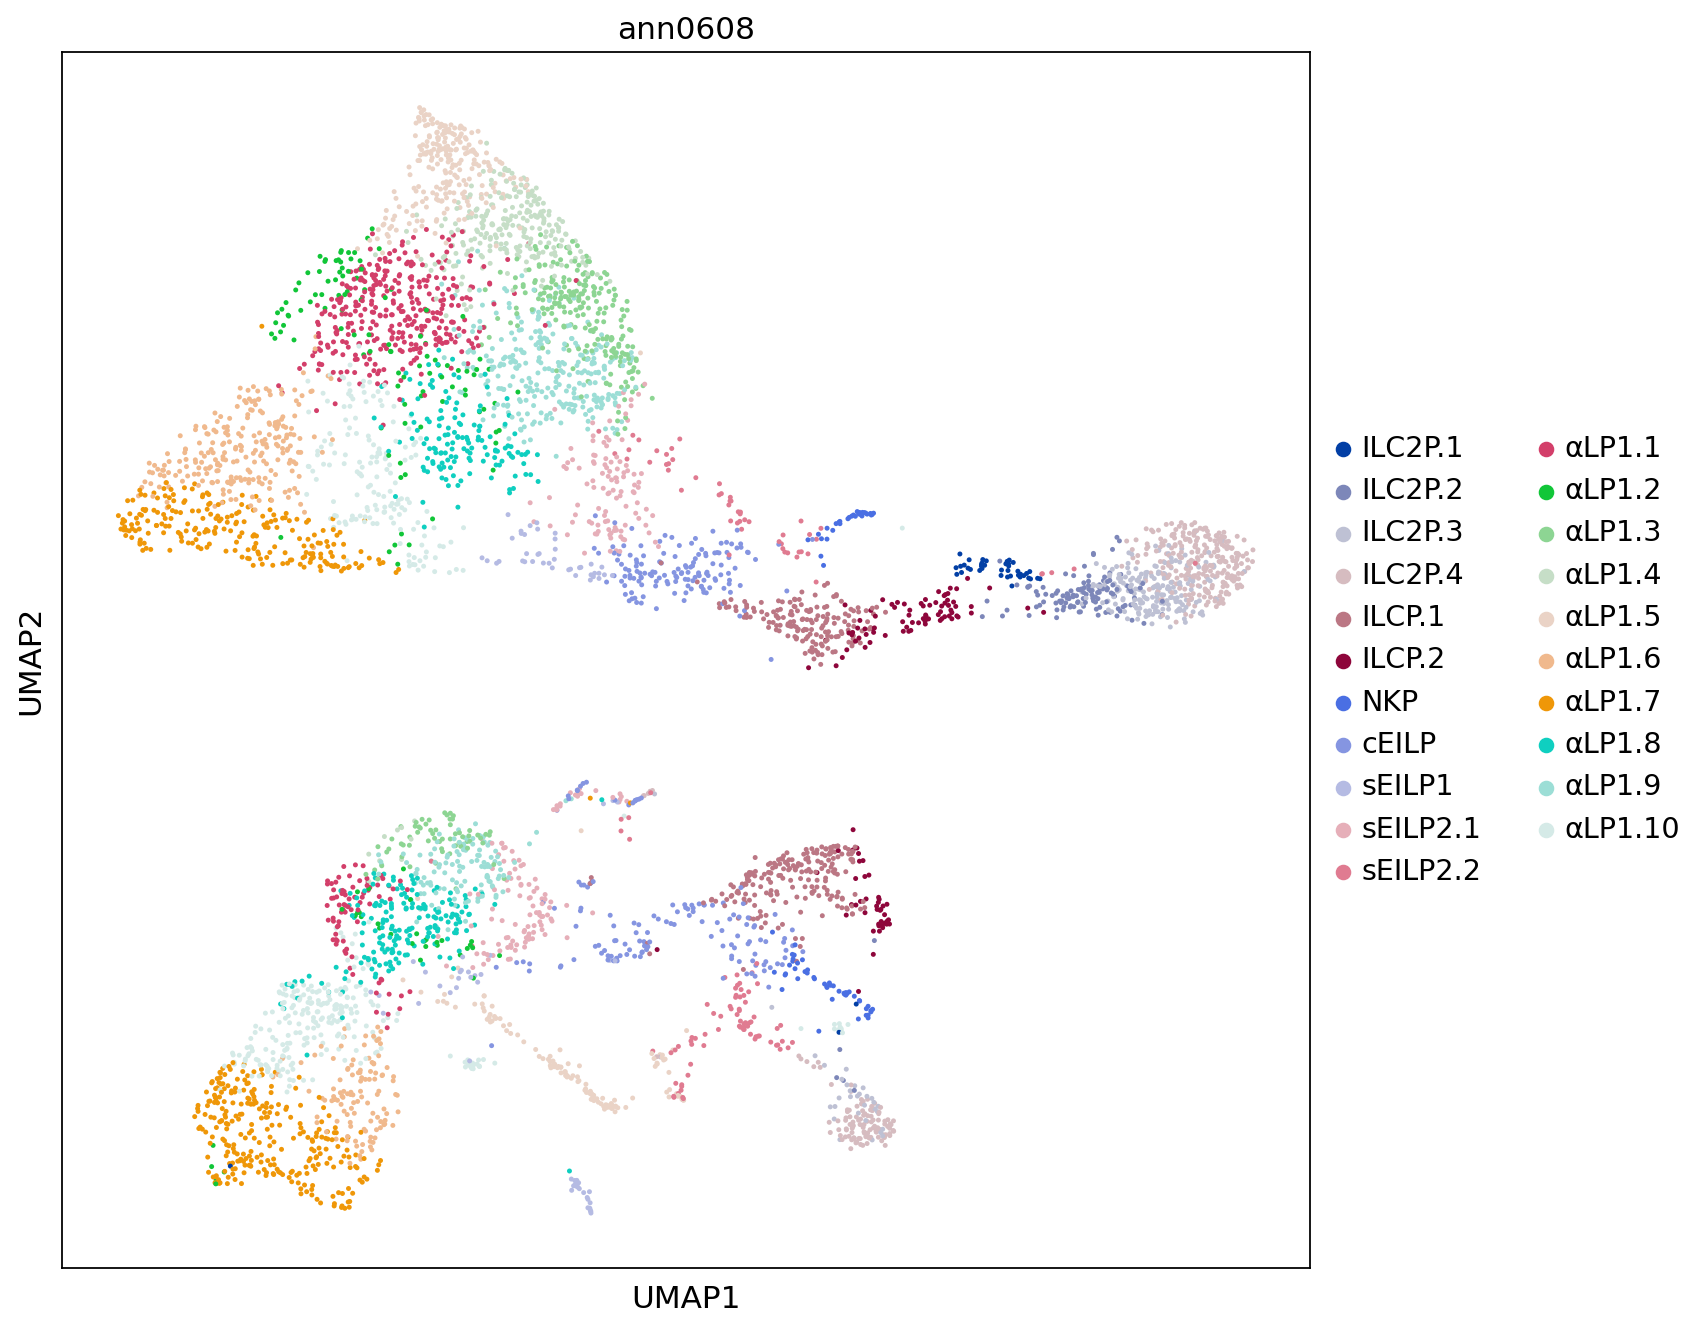

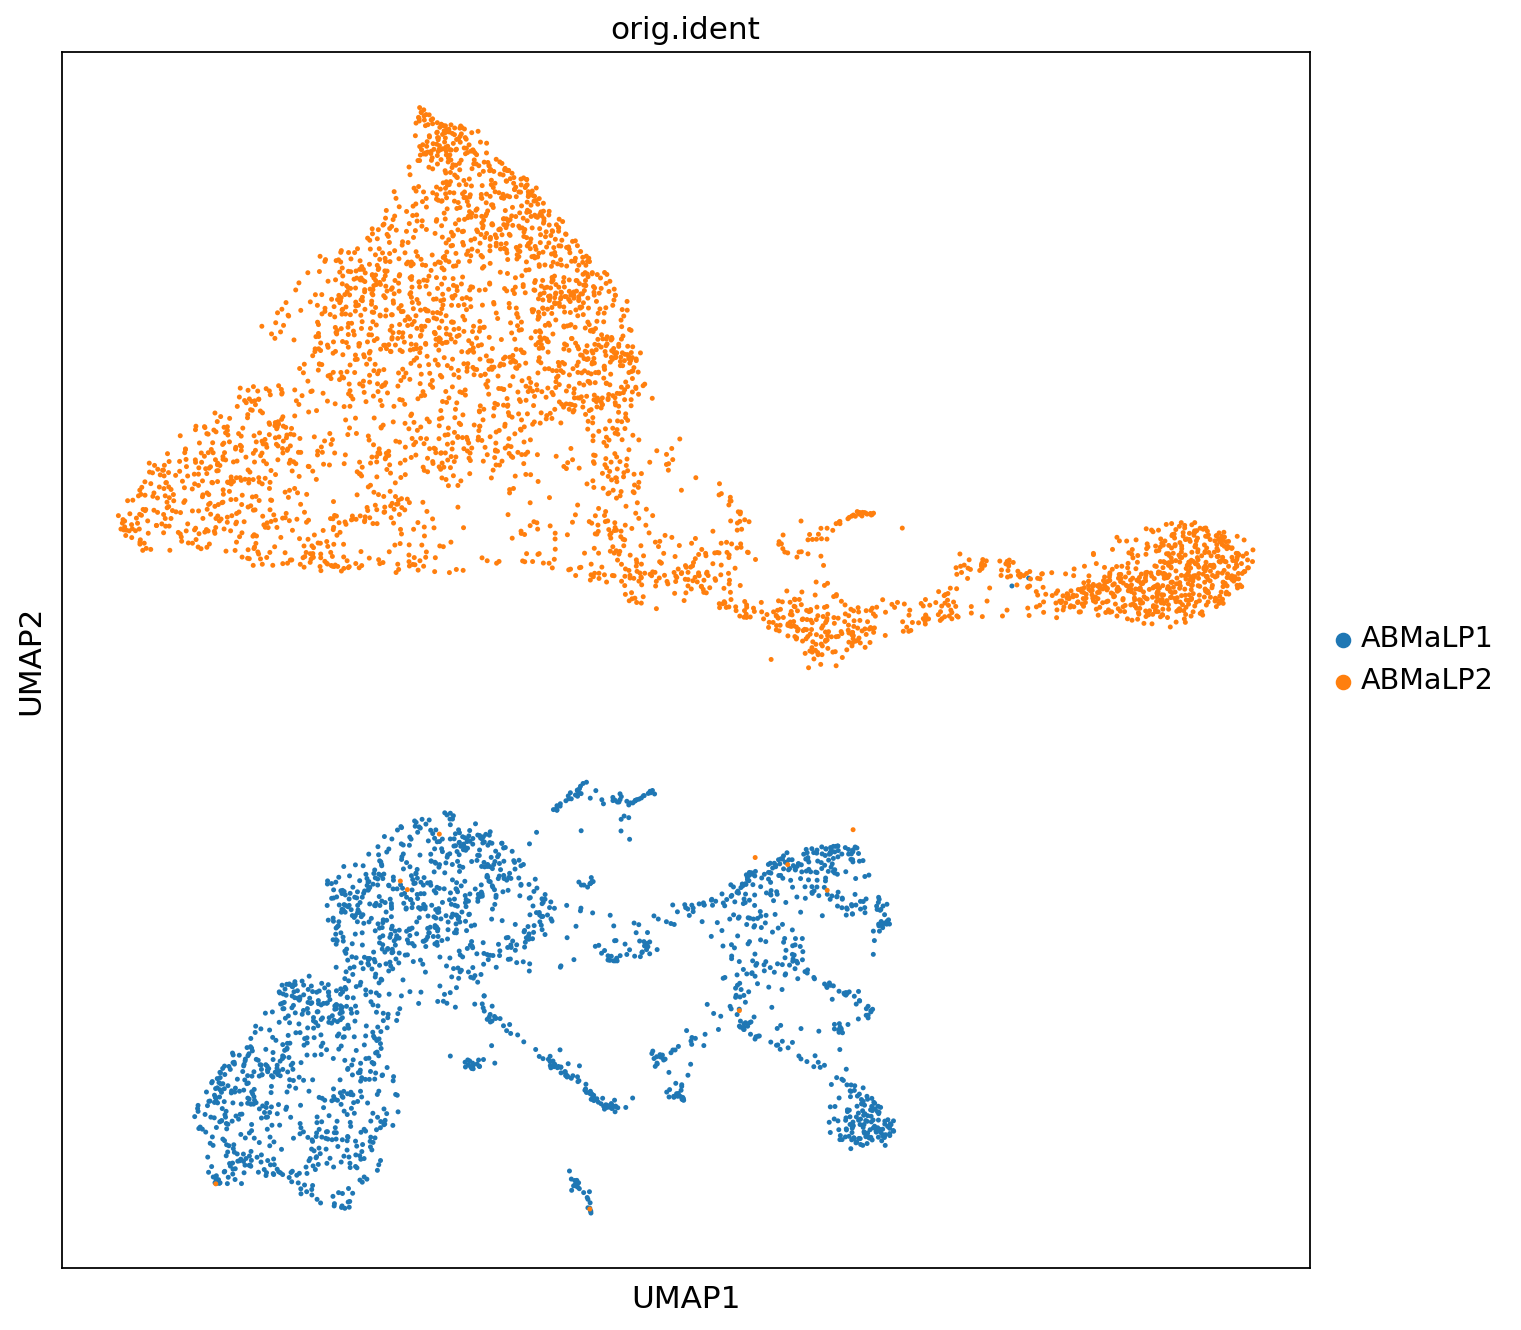

In [138]:
sc.settings.set_figure_params(figsize=[10,10])
sc.pl.umap(adata_combined, color=['ann0608' ], size=20)
sc.pl.umap(adata_combined, color=[ 'orig.ident'], size=20)

In [84]:
adata_combined.obs['batch_ann0608'] =adata_combined.obs['orig.ident'].astype(str)+"_"+adata_combined.obs['ann0608'].astype(str)


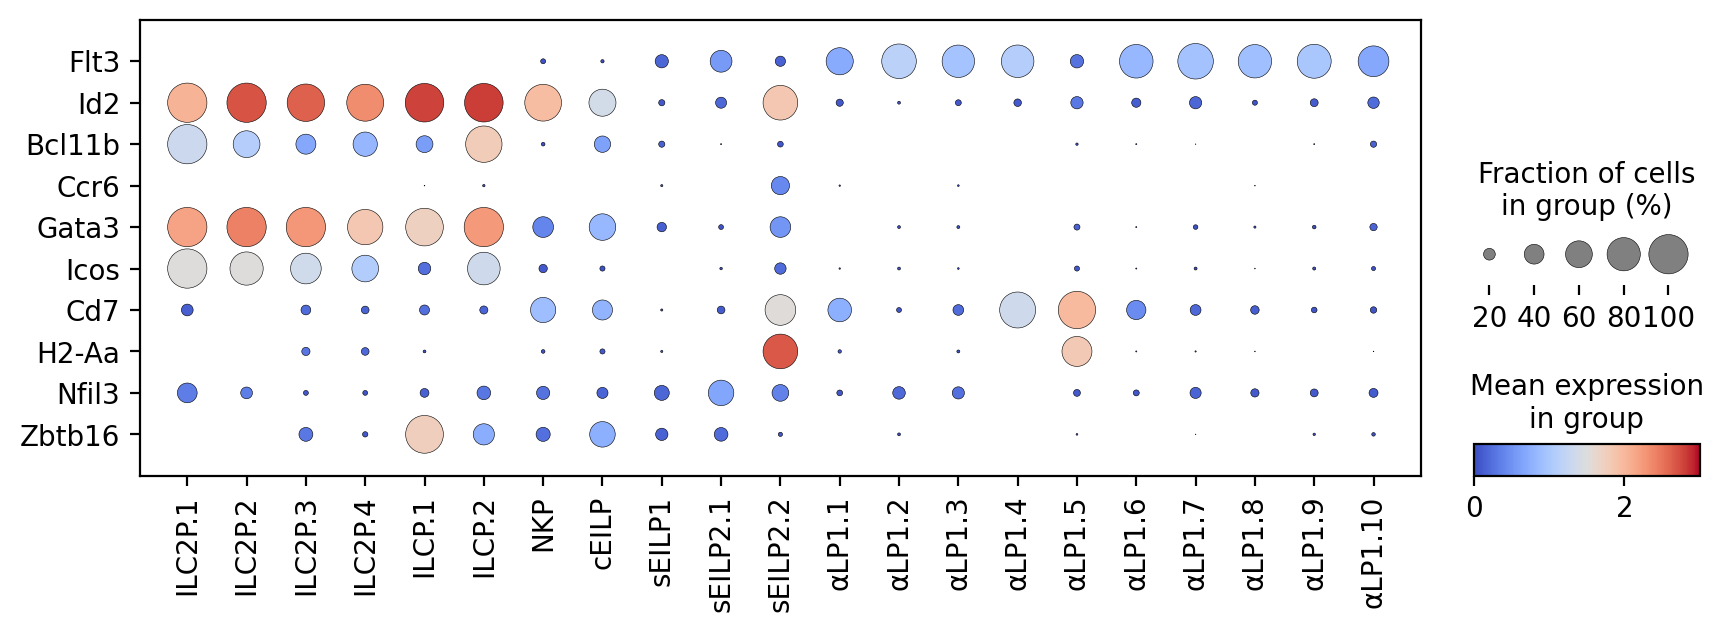

In [134]:
sc.pl.dotplot(adata_combined[adata_combined.obs['orig.ident']=='ABMaLP1'], 
              ['Flt3','Id2','Bcl11b','Ccr6','Gata3','Icos','Cd7','H2-Aa','Nfil3','Zbtb16'],
              groupby='ann0608', 
              vmin=0, vmax=3, cmap='coolwarm', dendrogram=False, swap_axes=True, figsize=(10,3))


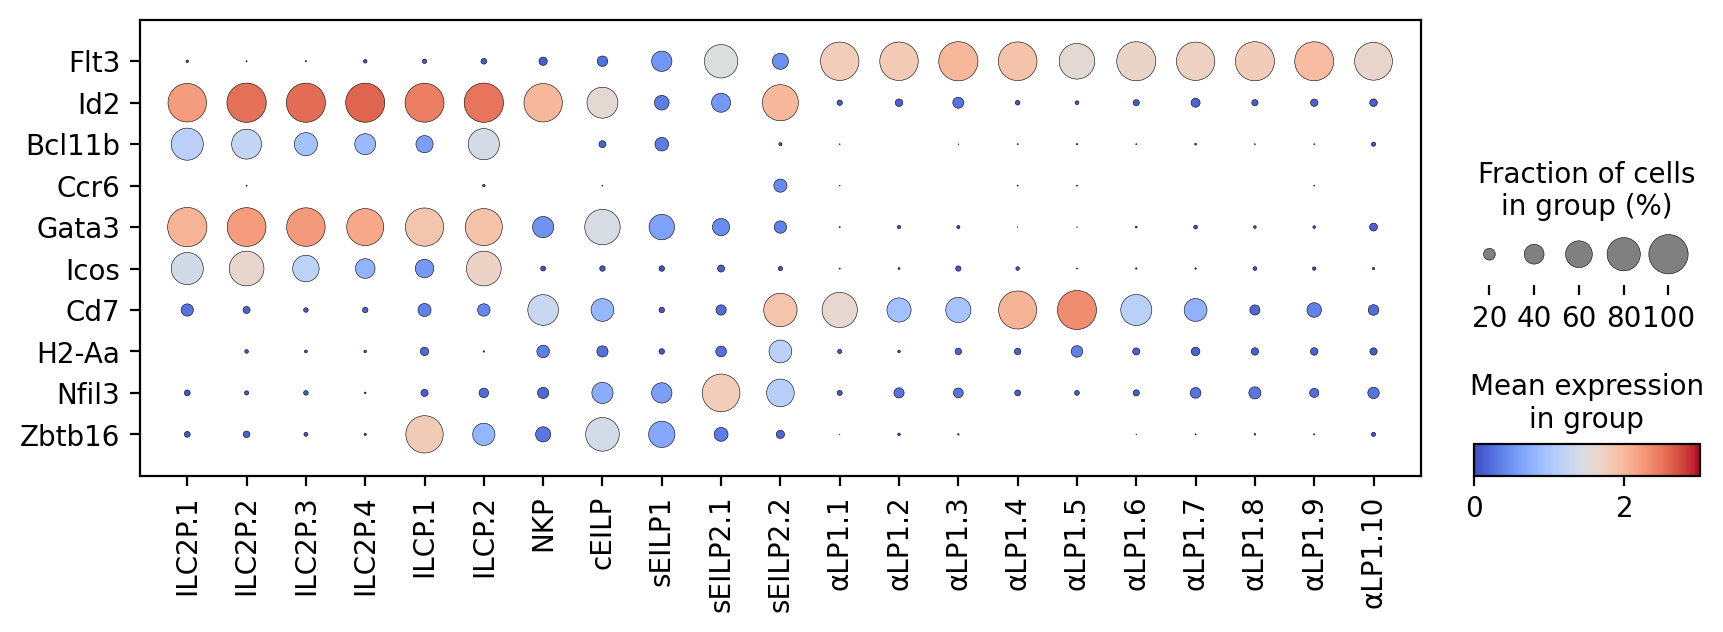

In [133]:
sc.pl.dotplot(adata_combined[adata_combined.obs['orig.ident']=='ABMaLP2'], 
              ['Flt3','Id2','Bcl11b','Ccr6','Gata3','Icos','Cd7','H2-Aa','Nfil3','Zbtb16'],
              groupby='ann0608', 
              #layer='scaled', 
              vmin=0, vmax=3, cmap='coolwarm', dendrogram=False, swap_axes=True, figsize=(10,3))


# construct a velocity loom

In [60]:
# load loom file
filename="/home/csj/mywork/ilc/200220-ILC_quants/20200210/velocyto_looms/ABMaLP1.loom"
ldata = scv.read(filename, cache=True)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [61]:
sel = adata_combined.obs['orig.ident']=='ABMaLP1'
adata=adata_combined[sel].copy()
adata.obs_names = [ss.split('_')[0] for ss in adata.obs_names.tolist()]

In [62]:
# rename barcodes
ldata.obs_names = [ss.split(':')[1].split('x')[0] for ss in ldata.obs_names.tolist()]
# reorder loom cells as in adata
ldata=ldata[adata.obs_names].copy()


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [67]:
adata.obsm["umap_integrated"]

array([[-0.86091627,  7.60170854],
       [-9.35324098, -6.92249047],
       [-1.00850303,  6.07113898],
       ...,
       [-0.3628434 ,  5.8095814 ],
       [ 4.64593696,  6.41049159],
       [ 2.41145419, -4.46827018]])

In [69]:
ldata.obsm["X_umap"]=adata.obsm["umap_integrated"]
ldata.obs=ldata.obs.drop(["_X","_Y"],axis=1)
ldata.obs['ann0608']=adata.obs["ann0608"]
ldata.obs.Clusters  =ldata.obs.Clusters.astype("category")


In [70]:
ldata.obs

,Clusters,ann0608
AAACCTGCAAATACAG,2,αLP1.10
AAACCTGGTTGGTAAA,2,αLP1.7
AAACCTGTCAGCGATT,9,sEILP1
AAACGGGCAAGTCTAC,3,αLP1.5
AAACGGGGTACATCCA,12,sEILP2.2
...,...,...
TTTGTCAAGTTGTCGT,1,αLP1.8
TTTGTCACACAACGTT,9,ILCP.2
TTTGTCAGTATCAGTC,0,sEILP1
TTTGTCAGTCATATCG,5,ILCP.1


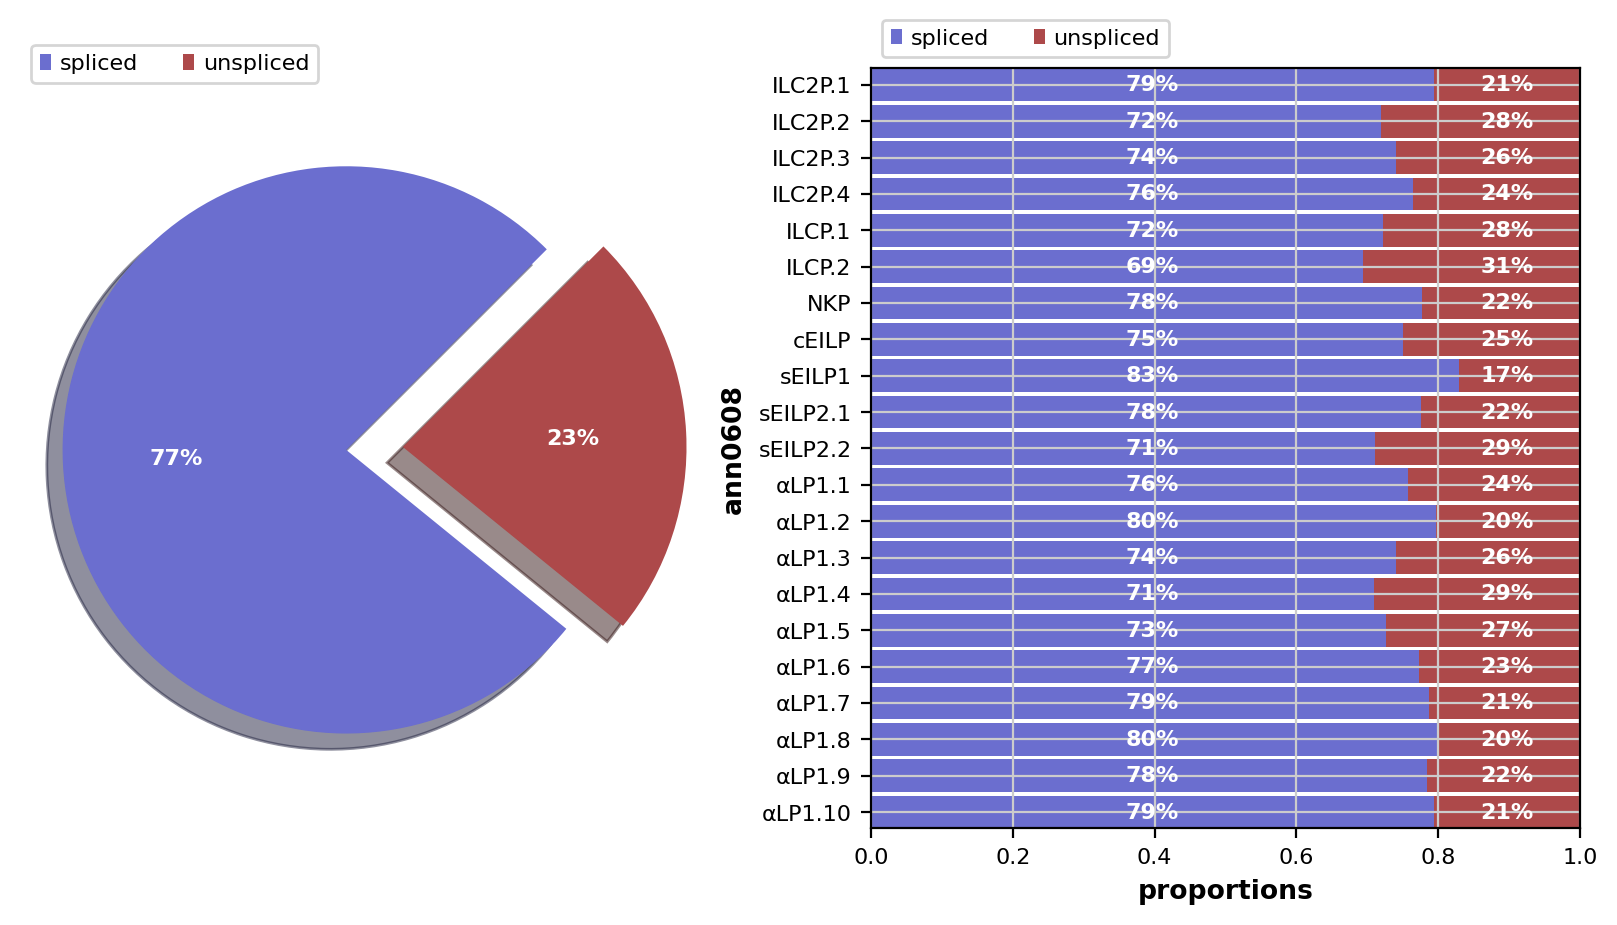

In [72]:
scv.pl.proportions(ldata,groupby="ann0608",figsize=[10,5])

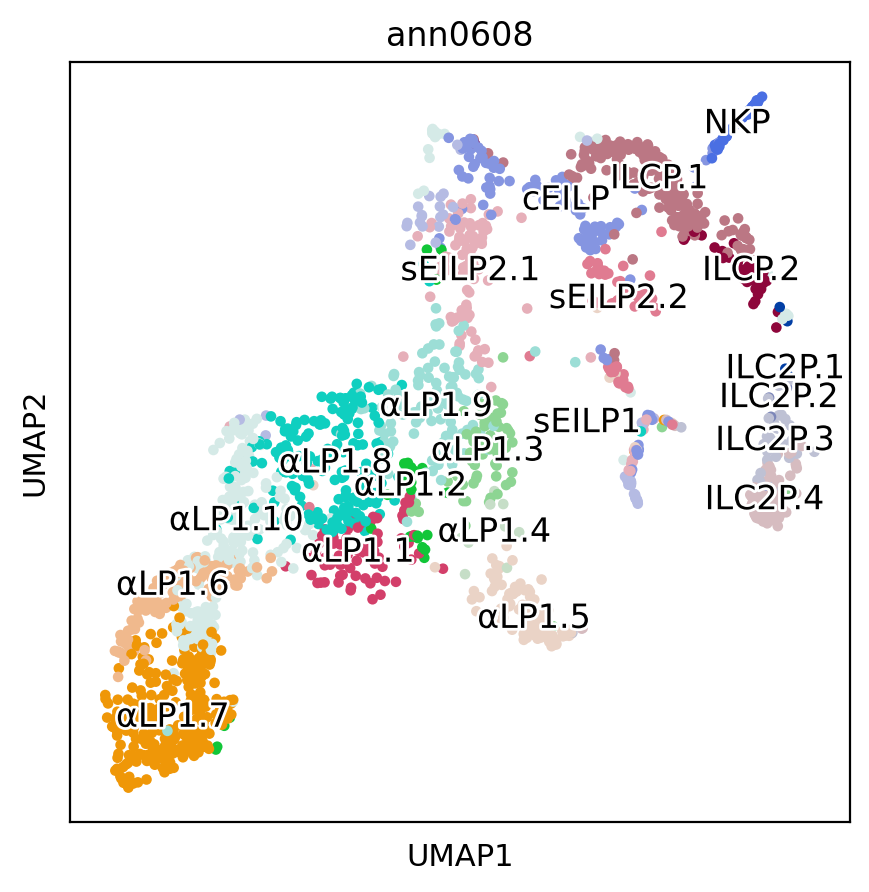

In [74]:
scv.set_figure_params(figsize=[5,5])
sc.pl.umap(ldata, color="ann0608",legend_loc='on data',legend_fontweight='light',legend_fontoutline=2)

In [75]:
ldata.write_h5ad("220516-ABM1.velo.h5ad")